#**M6 New Taipei City Real Estate Valuation Dataset**

The data associated with this notebook can be downloaded here: https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set



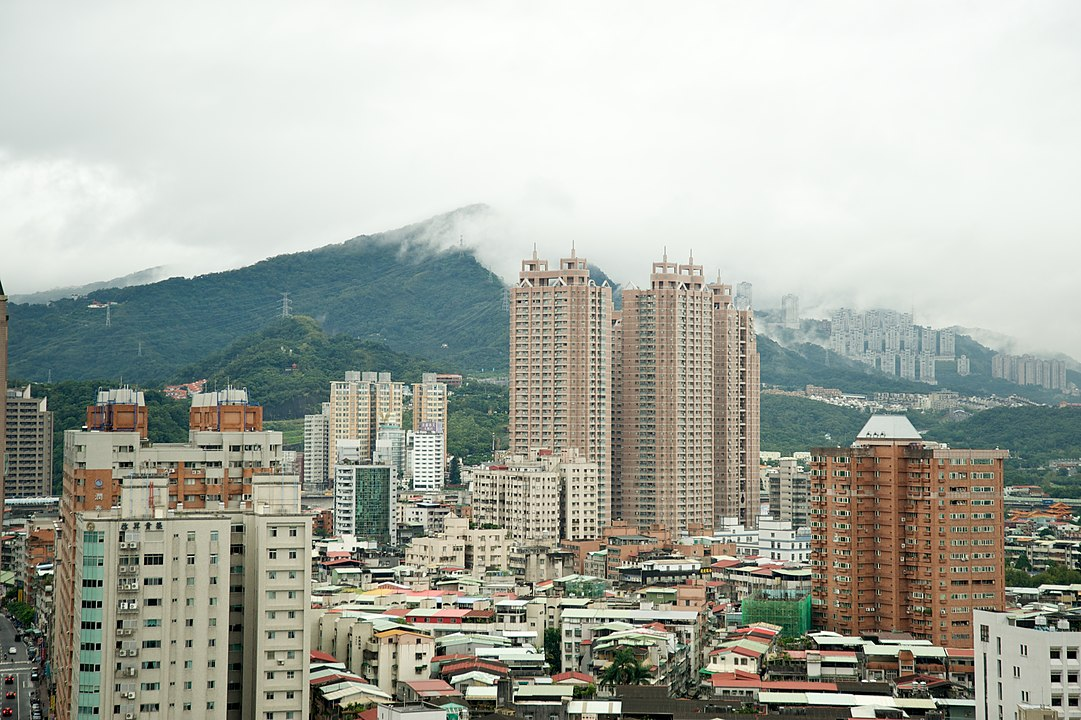

By Fred Hsu on en.wikipedia - Photo taken and uploaded by user, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=9600721

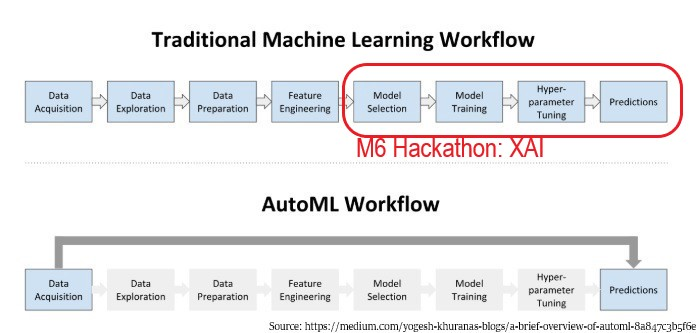

#**Table of Contents**
* Executive Summary (BLUF)
* Business Problem
* Conclusions from Data Preprocessing & Classification Notebooks
* Libraries
* Data
* Data Preprocesing
* Scaling & Holdout Sample
* RandomForestRegressor Model
  * Global Methods [RandmForestRegressor Model]
    * Feature Importance (Global)
    * SHAP Values (Global)
    * KDE Plots
    * Partial Dependence Plots
    * Surrogate Models (Global)   
  * Local Methods [RandomForestRegressor Model]
    * Shapley Values (Local)
    * LIME
    * Individual Conditonal Expectation (ICE) Plots
* XGBRegressor Model
  * Global Methods [XGBRegressor Model]
    * Feature Importance (Global)
    * SHAP Values (Global)
    * KDE Plots
    * Partial Dependence Plots
    * Surrogate Models (Global)   
  * Local Methods [XGBRegressor Model]
    * Shapley Values (Local)
* Conclusions

#**Executive Summary (BLUF)** 
Using two regressors (the RandomForestRegressor and XGBRegressor), we find that walking distance to the nearest MRT station is a significant driver of real estate value (especially those properties within about 1km of a station). Age and latitude are also important, with price decreasing, respectively increasing with age, respectively latitude.

#**Business Problem**
Sinyi Realty (信義房屋) is looking to develop a broad valuation story for investors in the New Taipei City real estate market using the features of the New Taipei City real estate valuation dataset.




#**Libraries**


In [ ]:
# Basic libraries
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import unique
from numpy import where
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import pyplot
import scipy.stats as ss
import math

In [ ]:
# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
!git clone --recursive https://github.com/dmlc/xgboost

fatal: destination path 'xgboost' already exists and is not an empty directory.


In [ ]:
from xgboost import XGBRegressor

In [ ]:
# Keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import graphviz

In [ ]:
# Update openpyxl
!pip install openpyxl==3.0.5


In [ ]:
!pip install shap==0.40.0
import shap

In [ ]:
!pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots

In [ ]:
!pip install lime
import lime
import lime.lime_tabular

#**Data**
The following is adaptedfrom https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set

The market historical data set of real estate valuation were collected from Sindian Dist., New Taipei City, Taiwan. 

Attribute Information:

The predictors/deatires are as follows:
- X1=the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)
- X2=the house age (unit: year)
- X3=the distance to the nearest MRT station (unit: meter)
- X4=the number of convenience stores in the living circle on foot (integer)
- X5=the geographic coordinate, latitude. (unit: degree)
- X6=the geographic coordinate, longitude. (unit: degree)

The target is as follows:
Y= house price of unit area (10000 New Taiwan Dollar/Ping, where Ping is a local unit, 1 Ping = 3.3 meter squared)

Note: X7_Cluster, a geographical cluster feature, based upon kMeans clustering of latitide and longitude, will be added during preprocessing.

In [ ]:
# Read data from UCI Machine Learning Repo
file_ = "https://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx"   
df = pd.DataFrame(pd.read_excel(file_)) # read in csv file

In [ ]:
# Head of df
df.head(10)

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1
5,6,2012.666667,7.1,2175.03000,3,24.96305,121.51254,32.1
6,7,2012.666667,34.5,623.47310,7,24.97933,121.53642,40.3
7,8,2013.416667,20.3,287.60250,6,24.98042,121.54228,46.7
8,9,2013.500000,31.7,5512.03800,1,24.95095,121.48458,18.8
9,10,2013.416667,17.9,1783.18000,3,24.96731,121.51486,22.1


#**Data Preprocessing**

In [ ]:
# Drop the index column (Column 0, "No")
if 'No' in df.columns:
  df = df.drop(["No"], axis = 1)

# The column names are verbose, so rename them (optional)
df.rename(columns = {"X1 transaction date": "X1_Date", "X2 house age": "X2_Age", "X3 distance to the nearest MRT station": "X3_MRT", "X4 number of convenience stores": "X4_Stores", "X5 latitude": "X5_Lat", "X6 longitude": "X6_Long", "Y house price of unit area": "Y_Price"},inplace = True)

# Examine the data using df.head() or df.tail()
print("HEAD of df\n", df.head()) 

HEAD of df
        X1_Date  X2_Age     X3_MRT  X4_Stores    X5_Lat    X6_Long  Y_Price
0  2012.916667    32.0   84.87882         10  24.98298  121.54024     37.9
1  2012.916667    19.5  306.59470          9  24.98034  121.53951     42.2
2  2013.583333    13.3  561.98450          5  24.98746  121.54391     47.3
3  2013.500000    13.3  561.98450          5  24.98746  121.54391     54.8
4  2012.833333     5.0  390.56840          5  24.97937  121.54245     43.1


In [ ]:
# Split Predictors & Target
X = pd.DataFrame(df.drop(['Y_Price'],axis=1))
y = pd.DataFrame(df['Y_Price']) 
y.columns = ['Y_Price']
print('X:\n',X.head())
print('\ny\n',y.head())

X:
        X1_Date  X2_Age     X3_MRT  X4_Stores    X5_Lat    X6_Long
0  2012.916667    32.0   84.87882         10  24.98298  121.54024
1  2012.916667    19.5  306.59470          9  24.98034  121.53951
2  2013.583333    13.3  561.98450          5  24.98746  121.54391
3  2013.500000    13.3  561.98450          5  24.98746  121.54391
4  2012.833333     5.0  390.56840          5  24.97937  121.54245

y
    Y_Price
0     37.9
1     42.2
2     47.3
3     54.8
4     43.1


In [ ]:
# Check skewness of target
y.skew(axis = 0, skipna = True)

Y_Price    0.599853
dtype: float64

In [ ]:
# Code for skewness correction (see source below)
# Depending upon the characteritics of a feature (column), a log, Box-Cox or power transform is applied to normalize the distribution 

# -*- coding: utf-8 -*-
"""

"""

##################################################
# A function that will accept a pandas dataframe
# and auto-transforms columns that exceeds threshold value
#  -  Offers choice between boxcox or log / exponential transformation
#  -  Automatically handles negative values
#  -  Auto recognizes positive /negative skewness


def skew_autotransform(DF, include = None, exclude = None, plot = False, threshold = 1, exp = False):
    
    #Get list of column names that should be processed based on input parameters
    if include is None and exclude is None:
        colnames = DF.columns.values
    elif include is not None:
        colnames = include
    elif exclude is not None:
        colnames = [item for item in list(DF.columns.values) if item not in exclude]
    else:
        print('No columns to process!')
    
    #Helper function that checks if all values are positive
    def make_positive(series):
        minimum = np.amin(series)
        #If minimum is negative, offset all values by a constant to move all values to positive teritory
        if minimum <= 0:
            series = series + abs(minimum) + 0.01
        return series
    
    
    #Go through desired columns in DataFrame
    for col in colnames:
        #Get column skewness
        skew = DF[col].skew()
        transformed = True
        
        if plot:
            #Prep the plot of original data
            sns.set_style("darkgrid")
            sns.set_palette("Blues_r")
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            #ax1 = sns.distplot(DF[col], ax=axes[0])
            ax1 = sns.histplot(DF[col], ax=axes[0], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
            ax1.set(xlabel='Original ' + str(col))
        
        #If skewness is larger than threshold and positively skewed; If yes, apply appropriate transformation
        if abs(skew) > threshold and skew > 0:
            skewType = 'positive'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply log transformation 
               DF[col] = DF[col].apply(math.log)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
         
        elif abs(skew) > threshold and skew < 0:
            skewType = 'negative'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply exp transformation 
               DF[col] = DF[col].pow(10)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
        
        else:
            #Flag if no transformation was performed
            transformed = False
            skew_new = skew
        
        #Compare before and after if plot is True
        if plot:
            print('\n ------------------------------------------------------')     
            if transformed:
                print('\n %r had %r skewness of %2.2f' %(col, skewType, skew))
                print('\n Transformation yielded skewness of %2.2f' %(skew_new))
                sns.set_palette("Paired")
                #ax2 = sns.distplot(DF[col], ax=axes[1], color = 'r')
                ax2 = sns.histplot(DF[col], ax=axes[1], color="red", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='Transformed ' + str(col))
                plt.show()
            else:
                print('\n NO TRANSFORMATION APPLIED FOR %r . Skewness = %2.2f' %(col, skew))
                #ax2 = sns.distplot(DF[col], ax=axes[1])
                ax2 = sns.histplot(DF[col], ax=axes[1], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='NO TRANSFORM ' + str(col))
                plt.show()
    return DF

In [ ]:
# Use code above (adapted from https://github.com/datamadness/Automatic-skewness-transformation-for-Pandas-DataFrame) to correct skewness
X = skew_autotransform(X.copy(deep=True), include=['X3_MRT'],plot = False, exp = False, threshold = 1)

# Unfortunately there is a defect in the boxcox method and X6_Long cannot be transformed

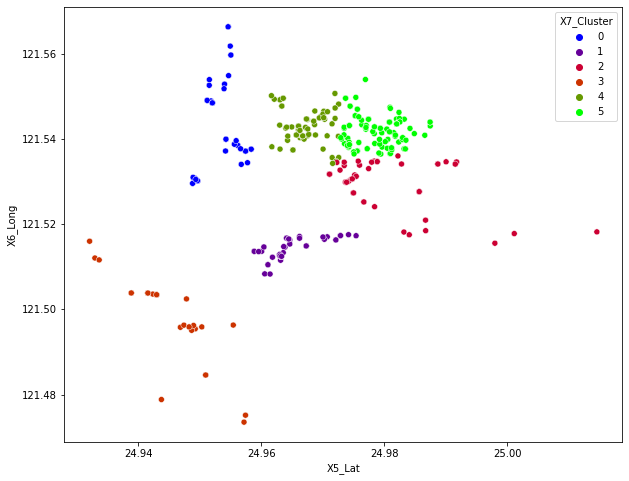

In [ ]:
# k-means clustering of latitudes & longitudes
# define the model
model = KMeans(n_clusters=6)
# fit the model
model.fit(X[['X5_Lat','X6_Long']])
# assign a cluster to each example
yhat = pd.DataFrame(model.predict(X[['X5_Lat','X6_Long']]),columns=['X7_Cluster'])
if 'X7_Cluster' not in X:
  X = pd.concat([X,yhat],axis=1)
else:
  X['X7_Cluster'] = yhat
colors = ['#747FE3', '#8EE35D', '#E37346']
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(10,8))
sns.scatterplot(x='X5_Lat', y='X6_Long', data=X, hue='X7_Cluster', palette = "brg")


In [ ]:
# record feature labels
Xcols = X.columns

In [ ]:
# Tukey Rule outliers for target (price/ping)
def tukey_rule(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_lim = data[col].quantile(0.5) + 2 * IQR
    lower_lim = data[col].quantile(0.5) - 2 * IQR
    outliers = []
    for index, x in enumerate(data[col]):
        if x < lower_lim or x >= upper_lim:
            outliers.append(index)
    return outliers

# # Identify outliers
# print('OUTLIERS:\n)')
col = 'Y_Price'
outliers_Tukey = tukey_rule(y,col)
# print("Column ",col,": ",outliers_Tukey)
X = X.drop(labels=outliers_Tukey, axis=0)
y = y.drop(labels=outliers_Tukey, axis=0)


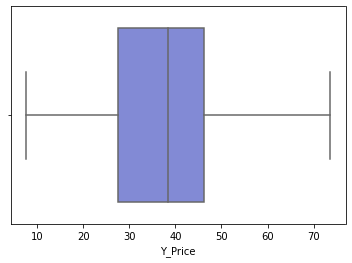

In [ ]:
# Boxplot y to check outliers
sns.boxplot(x=y['Y_Price'])

#**Scaling & Holdout Sample**

In [ ]:
# Create holdout sample
# Note: split before doing any trasformations on the data!!!

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.2,    # 80-20 training vs test set split
                     random_state=0)
# print('Shape of X and y',X.shape, y.shape, '\nShape of training set X and y',X_train.shape, y_train.shape, '\nShape of test set X and y',X_test.shape, y_test.shape) 


In [ ]:
# Bringing features onto the same scale：normalization and standardization:

# Min-max scaling(Normalization) (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

# mms = MinMaxScaler()
# X_norm = mms.fit_transform(X)

# Standardization z-score  (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
# from sklearn.preprocessing import StandardScaler
stdsc1 = StandardScaler()  
X_train_std = stdsc1.fit_transform(X_train)
X_test_std = stdsc1.transform(X_test)
stdsc2 = StandardScaler()  
y_train_std = stdsc2.fit_transform(y_train)
y_test_std = stdsc2.transform(y_test)

In [ ]:
# Ensdure training and test data are in pandas dataframes
X_train_std =  pd.DataFrame(X_train_std,columns = X.columns)
X_test_std = pd.DataFrame(X_test_std,columns = X.columns)
y_train_std = pd.DataFrame(y_train_std)
y_test_std = pd.DataFrame(y_test_std)

#**RandomForestRegressor Model**

In [ ]:
# Gridsearch a RandomForestRegressorRegressor some of the hyperparameter space
model = RandomForestRegressor(criterion='squared_error',random_state=1221)    
# define the grid of values to search
grid = dict()
grid['max_leaf_nodes']= [100, 200]
grid['max_depth']= [5, 7, 9]
grid['n_estimators'] = [400, 1000]
cv = RepeatedKFold(n_splits=3, n_repeats=2, random_state=192837465)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(X_train_std, y_train_std)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.220712 using {'max_depth': 9, 'max_leaf_nodes': 200, 'n_estimators': 400}
-0.229789 (0.040567) with: {'max_depth': 5, 'max_leaf_nodes': 100, 'n_estimators': 400}
-0.230188 (0.039849) with: {'max_depth': 5, 'max_leaf_nodes': 100, 'n_estimators': 1000}
-0.229789 (0.040567) with: {'max_depth': 5, 'max_leaf_nodes': 200, 'n_estimators': 400}
-0.230188 (0.039849) with: {'max_depth': 5, 'max_leaf_nodes': 200, 'n_estimators': 1000}
-0.221966 (0.044340) with: {'max_depth': 7, 'max_leaf_nodes': 100, 'n_estimators': 400}
-0.222579 (0.043172) with: {'max_depth': 7, 'max_leaf_nodes': 100, 'n_estimators': 1000}
-0.221966 (0.044340) with: {'max_depth': 7, 'max_leaf_nodes': 200, 'n_estimators': 400}
-0.222579 (0.043172) with: {'max_depth': 7, 'max_leaf_nodes': 200, 'n_estimators': 1000}
-0.220726 (0.046120) with: {'max_depth': 9, 'max_leaf_nodes': 100, 'n_estimators': 400}
-0.220924 (0.044885) with: {'max_depth': 9, 'max_leaf_nodes': 100, 'n_estimators': 1000}
-0.220712 (0.046098) with: {'max

In [ ]:
# Fit RandomForestRegressor on holdout sample
#regr = RandomForestRegressor(criterion ='squared_error',max_leaf_nodes=200,max_depth=9,n_estimators=400,random_state=1221)
regr = RandomForestRegressor(criterion='squared_error',random_state=1221, max_depth=9, max_leaf_nodes=200, n_estimators= 400)
regr.fit(X_train_std, np.ravel(y_train_std))
# Make predictions 
y_pred_train_std = regr.predict(X_train_std)
y_pred_std = regr.predict(X_test_std)
y_pred_std = pd.DataFrame(y_pred_std)
y_pred = stdsc2.inverse_transform(y_pred_std)
y_pred_train_std = pd.DataFrame(y_pred_train_std)
y_pred_std = pd.DataFrame(y_pred_std)
y_pred = pd.DataFrame(y_pred)

##**Global Methods [RandomForestRegressor Model]**

###*Feature Importance(Global)*

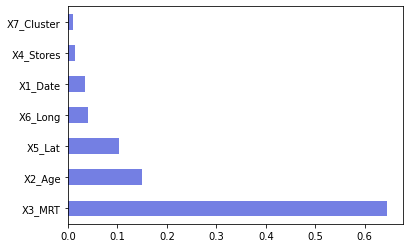

In [ ]:
# Feature Importance using the builtin in RandomForestRegressor (based upon impurity analysis)
RF_feature_importances = pd.Series(regr.feature_importances_, index=Xcols)
RF_feature_importances.nlargest(10).plot(kind='barh')

###*Shapey Values (Global)**

In [ ]:
# ex = shap.KernelExplainer(regr.predict, X_train_std)
# shap_values = ex.shap_values(X_test.iloc[0,:])

  0%|          | 0/328 [00:00<?, ?it/s]

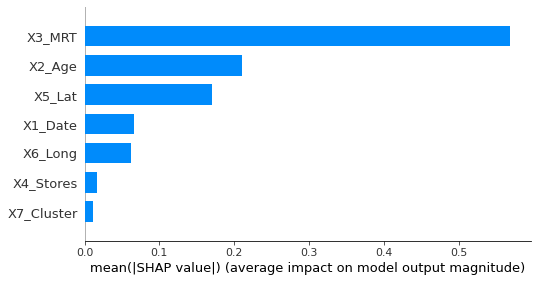

In [ ]:
# Global (i.e., model-level) Shapley values
# ***************** COMPUTATIONALLY EXPENSIVE (~6min on Colab Pro ***********************

# explainer = shap.KernelExplainer(regr.predict, X_train_std)
explainer = shap.SamplingExplainer(regr.predict, X_train_std)
shap_values = explainer.shap_values(X_train_std)
shap.summary_plot(shap_values, X_train_std, plot_type='bar',feature_names=Xcols)

X3_MRT is clearly the most important feature in both the RandomForestRegressor importance analysis and Shapley value analysis. Notice the gap in the distribution of instances in the X3_MRT distribution. Age and latititude are in the top three in importance in both studies (and in the same order of importance). These results suggest that we can build a reasonable story around walking distance to the MRT (Taipei Metro), refined with consideration of age and latitude of a property.

###*Partial Dependence Plots* 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


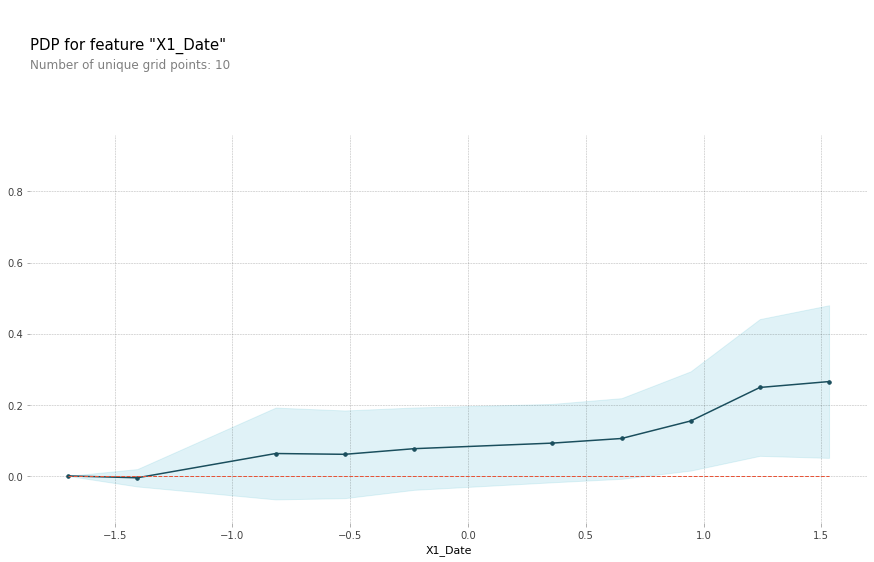

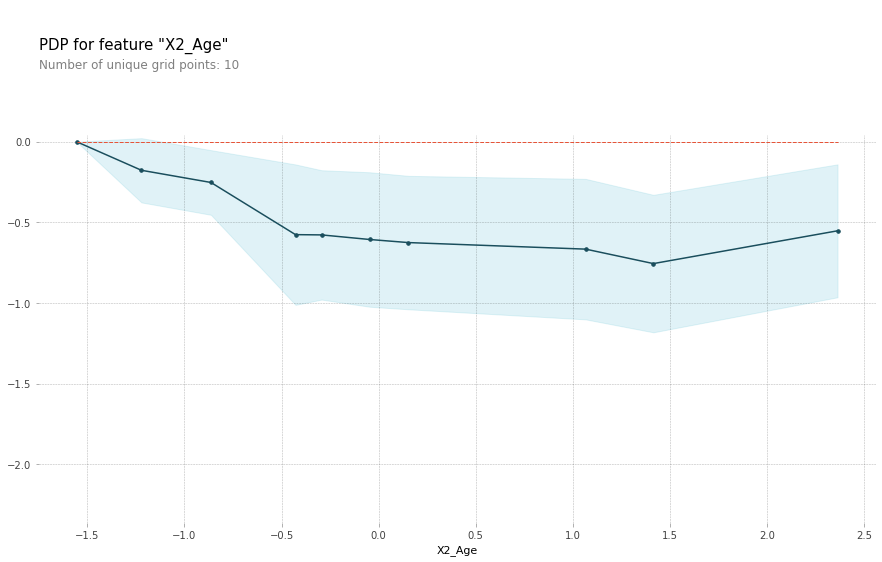

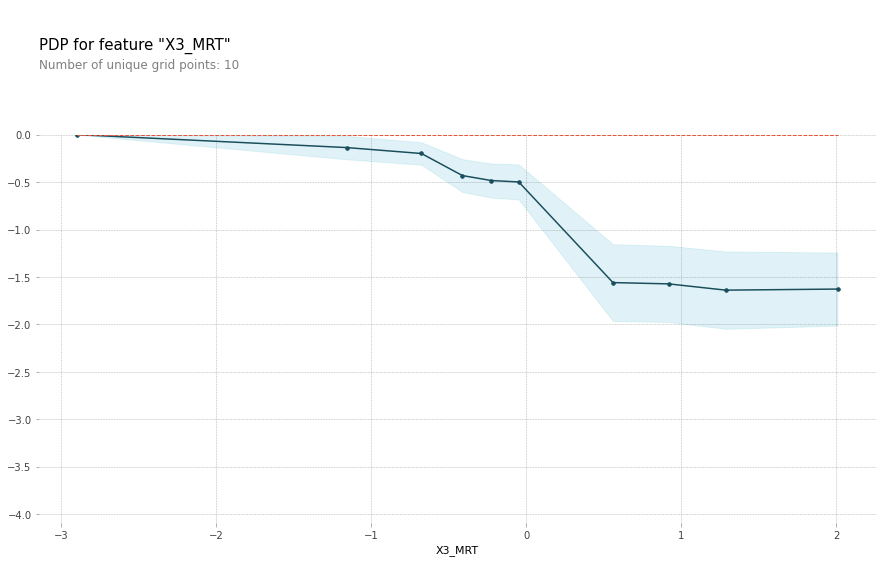

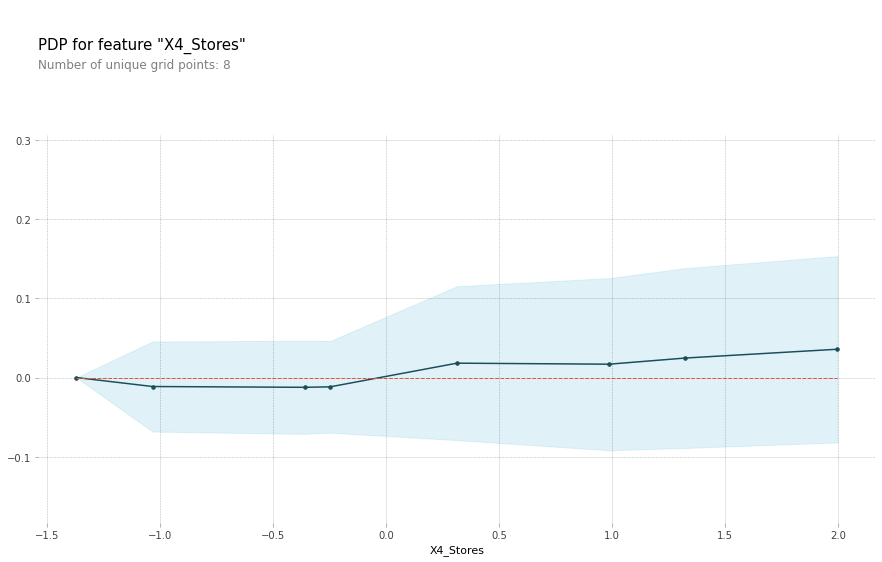

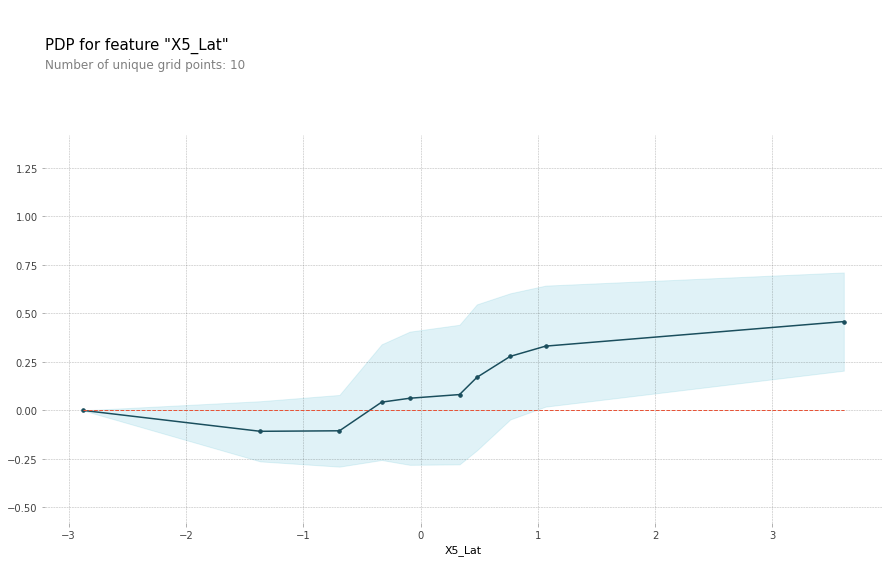

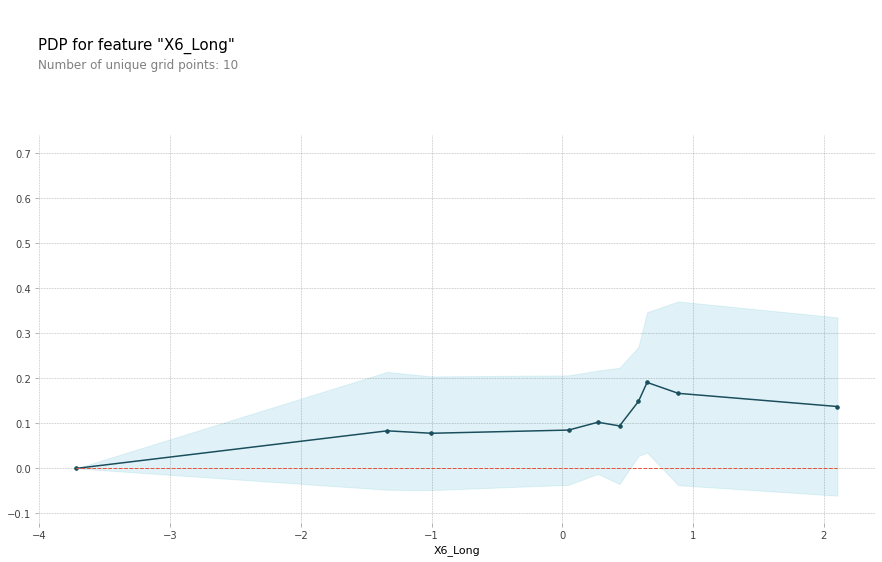

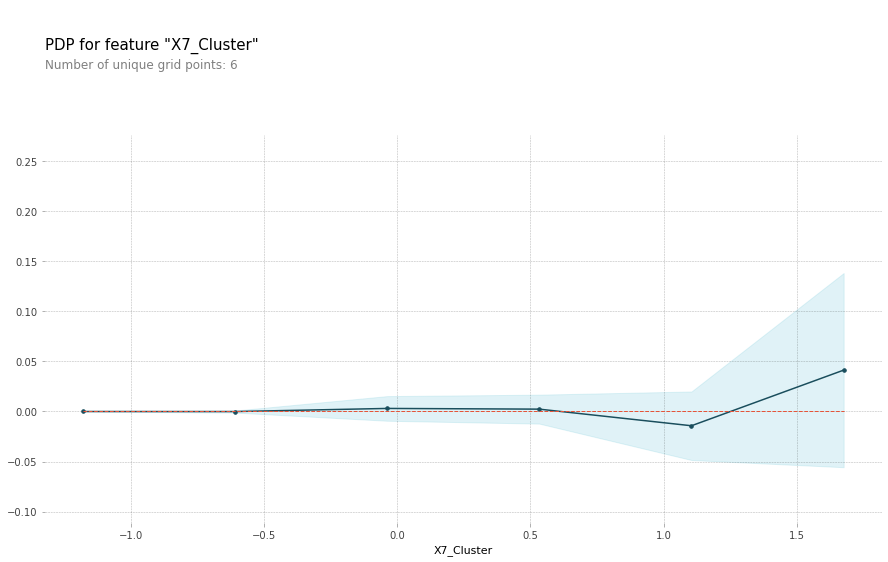

In [ ]:
# PDPs
for i in X.columns:    
    pdp_ = pdp.pdp_isolate(model = regr, dataset = X_train_std, model_features = X.columns, feature = i, n_jobs=1) 
    pdp.pdp_plot(pdp_, str(i))
    plt.show()

In [ ]:
# Review mean and standard deviation of X3_MRT feature
df.describe(include = ['float64'])

,X1_Date,X2_Age,X3_MRT,X5_Lat,X6_Long,Y_Price
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148953,17.712560,1083.885689,24.969030,121.533361,37.980193
std,0.281995,11.392485,1262.109595,0.012410,0.015347,13.606488
min,2012.666667,0.000000,23.382840,24.932070,121.473530,7.600000
25%,2012.916667,9.025000,289.324800,24.963000,121.528085,27.700000
50%,2013.166667,16.100000,492.231300,24.971100,121.538630,38.450000
75%,2013.416667,28.150000,1454.279000,24.977455,121.543305,46.600000
max,2013.583333,43.800000,6488.021000,25.014590,121.566270,117.500000


We see a significant change in X3_MRT in the partial dependence plot between standardized values of roughly 0 and 0.5. These correspond to values in the original scale of 1083 meters (the mean) and 1083 + 0.5(1262) = 1714 meters (the mean plus half a standard deviation). We can refine our story with the idea that property values are higher in areas with less than 1km walking distance to the nearest MRT station, and lower in areas more than 1.7km walking distance to the MRT.

Additionally, home values appear to generally decline in value with age, and increase above a standardized latitude of roughly -0.75. The latitude story is NOT compatible with the partial dependence plot for X7_Cluster.

The ICE plots do not show much separation between the different instances.

###*Surrogate Models (Global)*

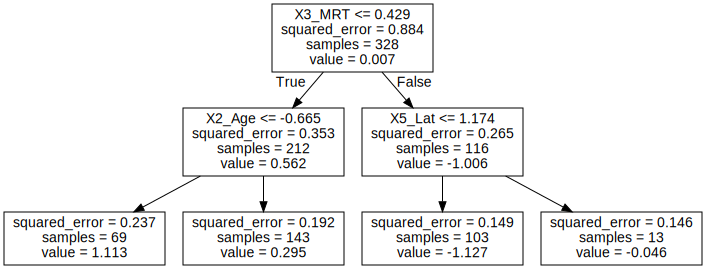

In [ ]:
# Decision Tree surrogate for RandomForestRegressor model
from sklearn.tree import DecisionTreeRegressor
import graphviz

proxy = DecisionTreeRegressor(random_state = 20850,max_depth=2)    # Control the depth of the surrogate model tree here
proxy.fit(X_train_std,y_pred_train_std)

tree_graph = tree.export_graphviz(proxy, out_file = None, feature_names = Xcols)
graphviz.Source(tree_graph)

A two-level surrogate decision tree model deploys the top three features identified using feature importance analysis. 

In [ ]:
# How good is this surrogate decision tree model? Let's find out...
y_proxy = proxy.predict(X_train_std) # Use the decision tree to make predictions
y_proxy = pd.DataFrame(y_proxy)
print('Correlation coefficient of RandomForestRegressor predictions and Surrogate Model predictions: ',y_pred_train_std.corrwith(y_proxy,axis=0))

Correlation coefficient of RandomForestRegressor predictions and Surrogate Model predictions:  0    0.88862
dtype: float64


In [ ]:
# Multiple Linear Regression surrogate model (for RandomForesRegerssor model)
import statsmodels.api as sm
model = sm.OLS(y_pred_train_std, X_train_std).fit()
predictions = model.predict(X_train_std) 
 
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                      0   R-squared (uncentered):                   0.827
Model:                            OLS   Adj. R-squared (uncentered):              0.823
Method:                 Least Squares   F-statistic:                              218.5
Date:                Wed, 04 May 2022   Prob (F-statistic):                   4.79e-118
Time:                        16:24:25   Log-Likelihood:                         -157.87
No. Observations:                 328   AIC:                                      329.7
Df Residuals:                     321   BIC:                                      356.3
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The top three features rank ordered by (absolute) magnitude are X3_MRT, X5_Lat and X2_Age. This is consistent with the rank ordering obtained using feature importance analysis. The model $R^2$ is quite satisfactory at about 0.83. 

##**Local Methods [RandomForestRegressor Model**

###*Shapley Values (Local)*
This area is under construction.


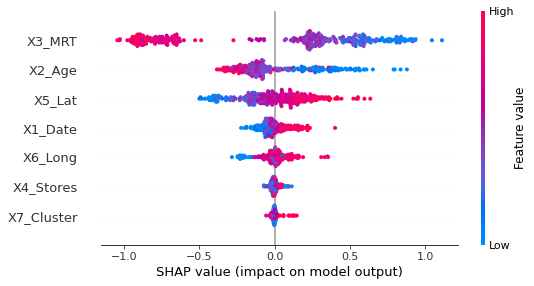

In [ ]:
# Check direction of impact (local Shapley values)
shap.summary_plot(shap_values, X_train_std,feature_names=Xcols)

###*LIME*

In [ ]:
# LIME 
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_std.values, feature_names=X.columns, class_names=['Y_Price'], categorical_features=[], verbose=True, mode='regression')
i = 25   # Examining instance 25
exp = explainer.explain_instance(X_train_std.loc[i], regr.predict, num_features=7)
exp.show_in_notebook(show_table=True)
print(f"The instance {i} standardized actual target value is {y_train_std.loc[i]} and is predicted (on the standardized scale) by the RandomForestRegressor to be {y_pred_std.loc[i]}")

Intercept -0.17321239309960085
Prediction_local [0.28894583]
Right: 0.48986734987220953


The instance 25 standardized actual target value is 0    0.23974
Name: 25, dtype: float64 and is predicted (on the standardized scale) by the RandomForestRegressor to be 0   -0.629291
Name: 25, dtype: float64


In [ ]:
exp.as_list()

[('X2_Age <= -0.77', 0.468963278630249),
 ('-0.63 < X3_MRT <= -0.17', 0.42057910788099356),
 ('X5_Lat <= -0.45', -0.3955675829775436),
 ('-0.37 < X6_Long <= 0.35', -0.04504954064666788),
 ('X7_Cluster > 0.53', 0.02659347997511379),
 ('-0.02 < X4_Stores <= 0.65', -0.01837400565709336),
 ('0.06 < X1_Date <= 0.95', 0.005013487497823988)]

While the assignment calls for a market-wide (i.e., global) account of the drivers of valuation, LIME explanations of valuation of individual properties are offered here for the sake of interest. 

###*Individual Conditional Expectation (ICE) Plots*

Computing partial dependence and ICE plots...


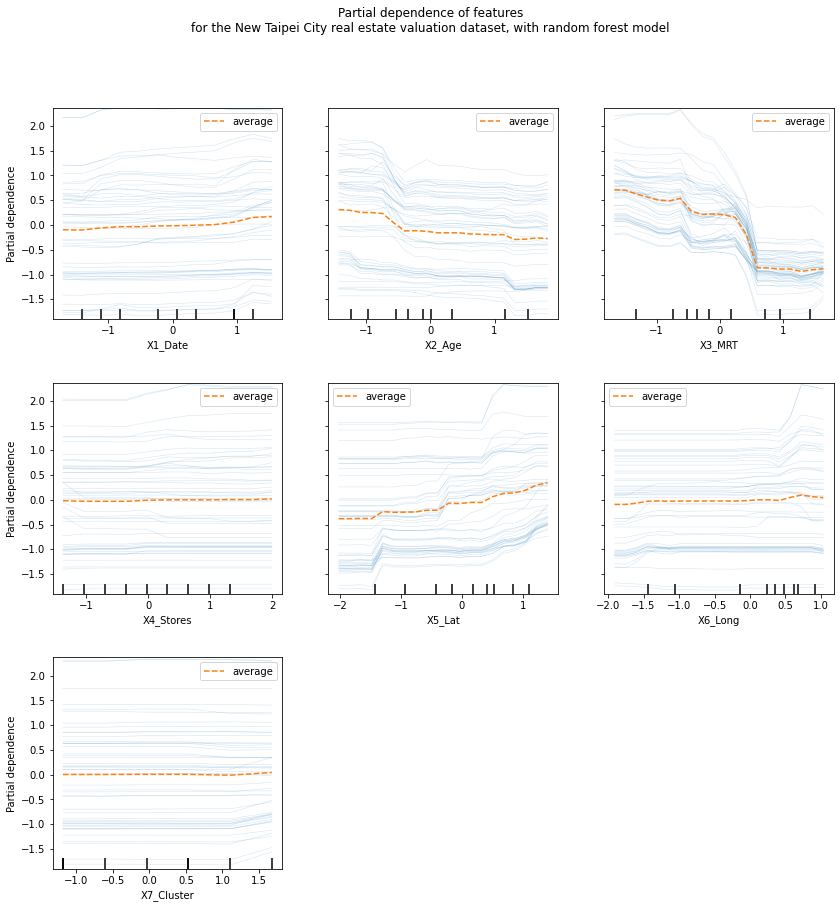

In [ ]:
# Create ICE plots
print("Computing partial dependence and ICE plots...")
features = X.columns
fig, ax = plt.subplots(figsize=(14, 14))
display = PartialDependenceDisplay.from_estimator(
    regr,
    X_train_std,
    features,
    kind="both",
    subsample=50,
    n_jobs=3,\
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"}, ax=ax
)
display.figure_.suptitle(
    "Partial dependence of features\n"
    "for the New Taipei City real estate valuation dataset, with random forest model"
)
display.figure_.subplots_adjust(hspace=0.3)

#**XGBRegressor Model**

In [ ]:
# Gridsearch an XGBoostRegressor hyperparameter space
model = XGBRegressor(objective ='reg:squarederror')    
# define the grid of values to search
grid = dict()
grid['learning_rate']= [.05, 0.07]
grid['max_depth']= [7, 9]
grid['n_estimators'] = [400]
cv = RepeatedKFold(n_splits=4, n_repeats=2, random_state=192837465)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(X_train_std, y_train_std)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.229712 using {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 400}
-0.229712 (0.047355) with: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 400}
-0.242602 (0.052317) with: {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 400}
-0.229928 (0.048618) with: {'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 400}
-0.243598 (0.050475) with: {'learning_rate': 0.07, 'max_depth': 9, 'n_estimators': 400}


In [ ]:
# Fit XGBRegressor on holdout sample
regr = XGBRegressor(objective ='reg:squarederror',learning_rate=0.07,max_depth=7,n_estimators=400)
regr.fit(X_train_std, np.ravel(y_train_std))
# Make predictions 
y_pred_train_std = regr.predict(X_train_std)
y_pred_std = regr.predict(X_test_std)
y_pred_std = pd.DataFrame(y_pred_std)
y_pred = stdsc2.inverse_transform(y_pred_std)
y_pred_train_std = pd.DataFrame(y_pred_train_std)
y_pred_std = pd.DataFrame(y_pred_std)
y_pred = pd.DataFrame(y_pred)

##**Global Methods [XGBRegressor Model]**

###*Feature Importance*

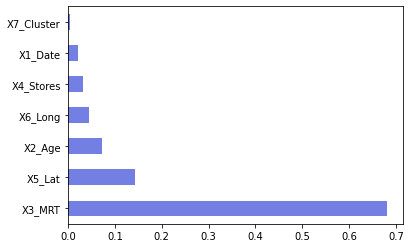

In [ ]:
XGB_feature_importances = pd.Series(regr.feature_importances_, index=Xcols)
XGB_feature_importances.nlargest(10).plot(kind='barh')

###*Shapey Values*

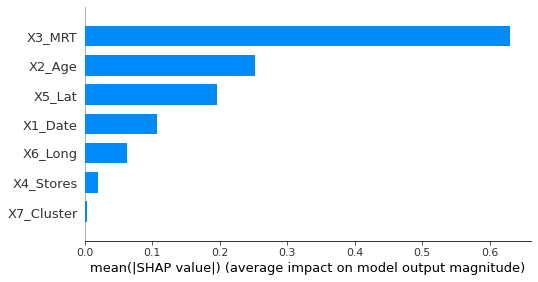

In [ ]:
# Global (i.e., model-level) Shapley values
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_train_std)
shap.summary_plot(shap_values, X_train_std, plot_type='bar',feature_names=Xcols)

X3_MRT is again clearly the most important feature in both the XGBRegressor importance and Shapley value analysis. The story is similar to the RandomForestRegressor, but Age and Latitude are not consistently rank ordered using the two feature importance methods for this regressor.

###*Partial Dependence Plots* 

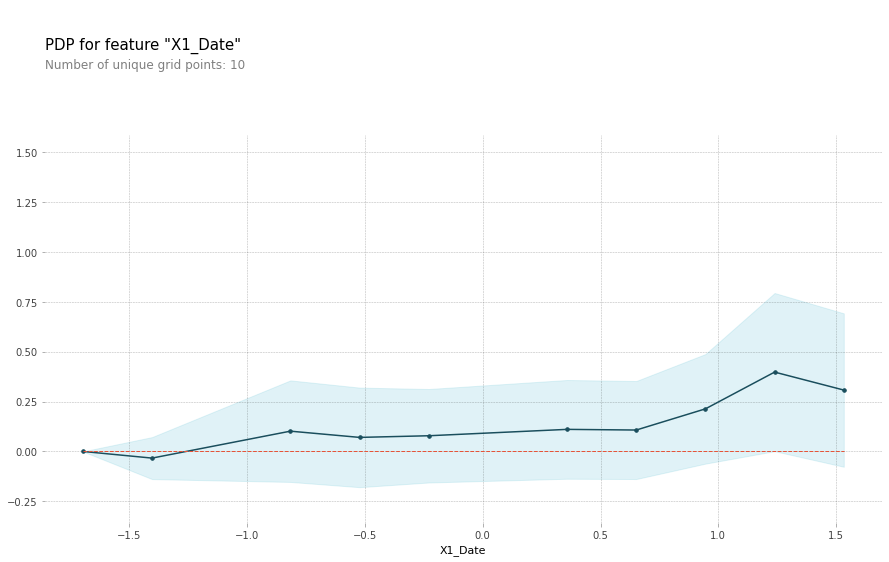

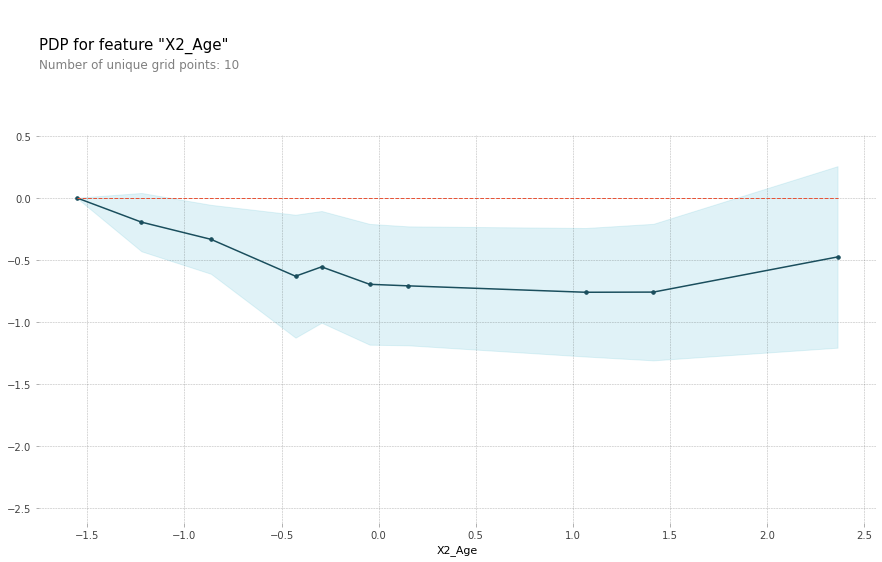

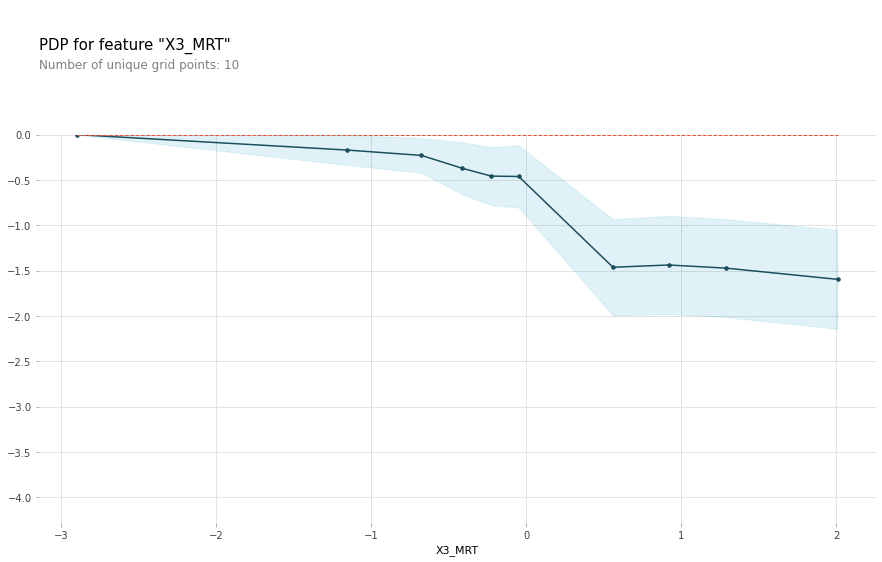

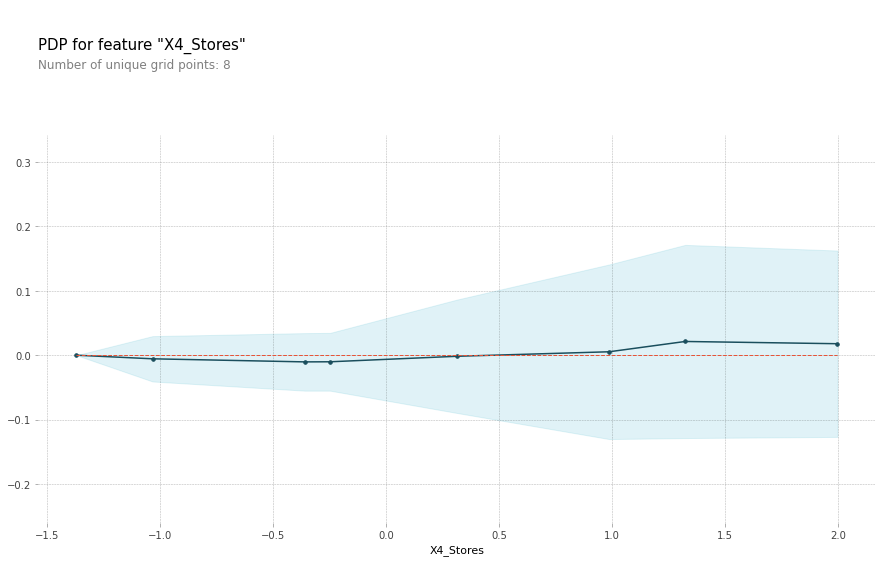

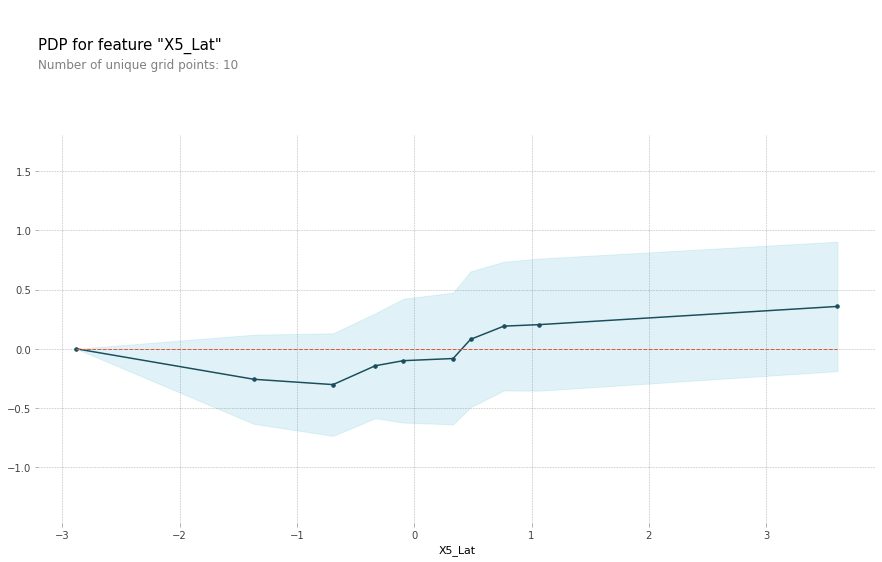

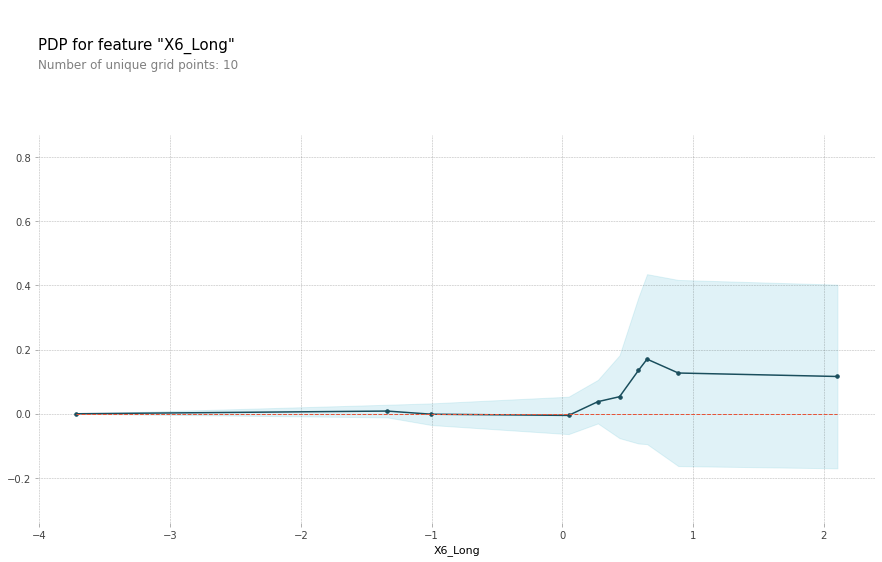

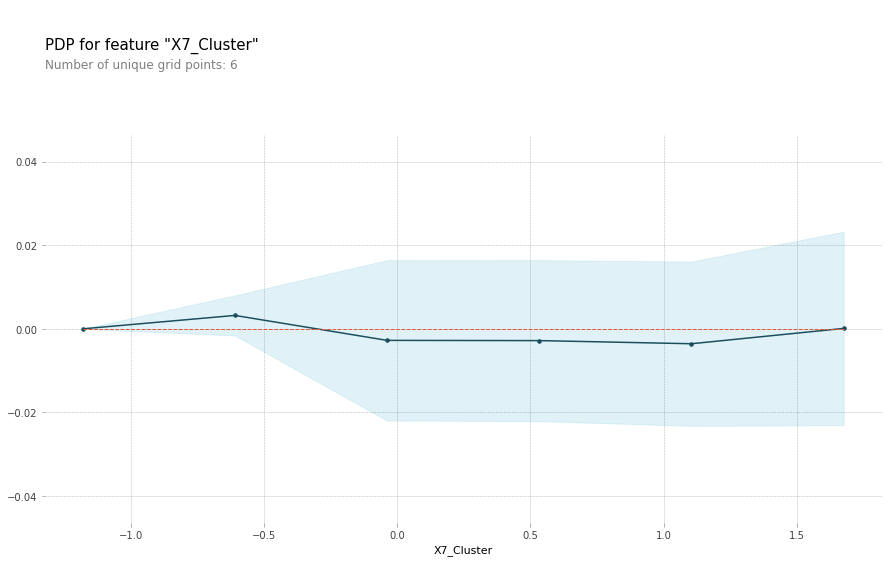

In [ ]:
# PDPs
for i in X.columns:    
    pdp_ = pdp.pdp_isolate(model = regr, dataset = X_train_std, model_features = X.columns, feature = i, n_jobs=1) 
    pdp.pdp_plot(pdp_, str(i))
    plt.show()

In [ ]:
# Descriptive statistics
df.describe()

,X1_Date,X2_Age,X3_MRT,X4_Stores,X5_Lat,X6_Long,Y_Price
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


As for the RandomForestRegessor, we see a significant change in X3_MRT in the partial dependence plot between standardized values of roughly 0 and 0.5. This consistency in the analysis using two different regressors suggests that our story likely has merit. 

###*Surrogate Models*

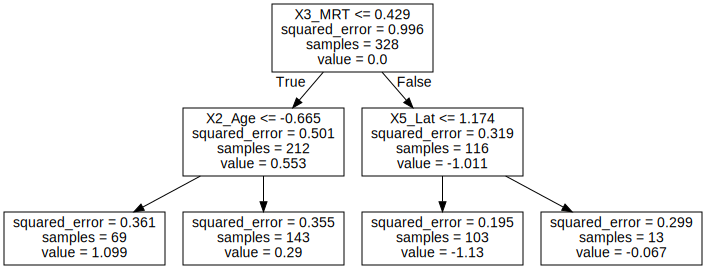

In [ ]:
# Decision Tree surrogate for XGBRegressor model
proxy = DecisionTreeRegressor(random_state = 20850,max_depth=2)    # Control the depth of the surrogate model tree here
proxy.fit(X_train_std,y_pred_train_std)

tree_graph = tree.export_graphviz(proxy, out_file = None, feature_names = Xcols)
graphviz.Source(tree_graph)

In [ ]:
# How good is this surrogate decision tree model? Let's find out...
y_proxy = proxy.predict(X_train_std) # Use the decision tree to make predictions
y_proxy = pd.DataFrame(y_proxy)
print('Correlation coefficient of XGBRegressor model predictions and Surrogate Model predictions: ',y_pred_train_std.corrwith(y_proxy,axis=0))

Correlation coefficient of XGBRegressor model predictions and Surrogate Model predictions:  0    0.83379
dtype: float64


A two-level surrogate decision tree model deploys the top three features identified using feature importance analysis. 

In [ ]:
# Multiple Linear Regression model (for XGBRegressor moel)
import statsmodels.api as sm
model = sm.OLS(y_pred_train_std, X_train_std).fit()
predictions = model.predict(X_train_std) 
 
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                      0   R-squared (uncentered):                   0.736
Model:                            OLS   Adj. R-squared (uncentered):              0.730
Method:                 Least Squares   F-statistic:                              127.9
Date:                Wed, 04 May 2022   Prob (F-statistic):                    6.48e-89
Time:                        16:25:24   Log-Likelihood:                         -246.23
No. Observations:                 328   AIC:                                      506.5
Df Residuals:                     321   BIC:                                      533.0
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The top three features rank ordered by (absolute) magnitude are X3_MRT, X2_Age and X5_Lat. The model $R^2$ is less satisfactory at about 0.74. 

##**Local Methods [XGBRegressor Model]**
This area is under construction

###*Shapley Values*


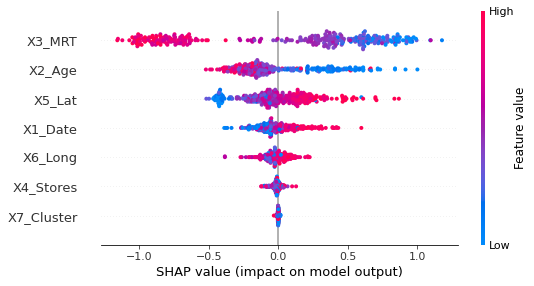

In [ ]:
# Check direction of impact (local Shapley values)
shap.summary_plot(shap_values, X_train_std,feature_names=Xcols)

#**Conclusion**
Using two regressors (the RandomForestRegressor and XGBRegressor), we find that walking distance to the nearest MRT station is a significant driver of real estate value (especially those properties within about 1km of a station). Age and latitude are also important, with price decreasing, respectively increasing with age, respectively latitude. 

Overall the results of the two models are very similar, but there are some discrepancies in the explainability analysis of them.


